In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Import libraries

import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from IPython.display import display, HTML
from IPython.display import Image

import seaborn as sns
from scipy import stats

import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

warnings.filterwarnings("ignore")

In [6]:
# Import dataset
cab_data = pd.read_csv('Cab_Data.csv')
customer_data = pd.read_csv('Customer_ID.csv')
transaction_data = pd.read_csv('Transaction_ID.csv')
city_data = pd.read_csv('City.csv')

FUNCTIONS TO RUN ANALYSIS ON EACH DATASET

In [7]:
#Function to show basic descriptive analysis of each dataset
def show_df(dataframe, head = 6):
    print ("------------------ Shape -------------------")
    print(f" Datashape: {dataframe.shape}")

    print("\n------------------ DataType -------------------")
    print(dataframe.dtypes)

    print("\n------------------ Head -------------------")
    print(dataframe.head(head))
    
    print("\n------------------ Null Value -------------------")
    print(dataframe.isnull().sum())

    print("\n------------------ Count -------------------")
    print(dataframe.count())

    print("\n------------------ nunique -------------------")
    print(dataframe.nunique())

    print("\n------------------ Desscribe -------------------")
    print(dataframe.describe())

In [8]:
# Functionf for checking duplicates
def find_duplicates(dataframe):
    duplicates = dataframe[dataframe.duplicated()]
    if duplicates.shape[0] == 0:
        print("No duplicate rows found in the dataframe.")
    else:
        print("Total {} duplicate rows found in the dataframe.".format(duplicates.shape[0]))
        print("Duplicate rows:")
        print(duplicates)

In [9]:
# Function for analyzing the columns in the dataframe and determines the categorical, numerical, and other columns

def get_col_names(dataframe, cat_th = 10, car_th = 20):
    
    #cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() >= car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")


    return cat_cols, num_cols, cat_but_car
    

In [10]:
# Function to perform analysis and visualization of categorical variables.

def cat_summ(dataframe, col_name, plot = True):

    value_counts = dataframe[col_name].value_counts()
    ratio = 100 * value_counts / len(dataframe)

    if plot:
        plt.figure(figsize = (8,4))
        sns.countplot( y = dataframe[col_name], data = dataframe, order = value_counts.index)
        plt.title(f"{col_name} Distribution")
        plt.xlabel("Count")
        plt.ylabel(col_name)
        plt.xticks(rotation = 0)

        for i, v in enumerate (value_counts.values):
            plt.text(v + 1, i, f"{v} ({ratio.iloc[i]:.2f}%", va = "center")

        plt.show()

In [11]:
# Function to perform analysis and visualization of numerical variables

def num_summ(dataframe, numerical_col, plot = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary = dataframe[numerical_col].describe(quantiles)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize = (18, 4))

        # Plot histogram
        dataframe[numerical_col].hist(bins = 20, ax = axes[0], color = "lightgreen")
        axes[0].set_xlabel(numerical_col)
        axes[0].set_title(numerical_col)

        # Displaying summary statistics as text
        summary_text = "\n".join([f"{col}:{value:.3f}" for col, value in summary.items()])
        axes[1].text(0.5, 0.5, summary_text, fontsize = 12, va = "center", ha = "left", linespacing = 1.5)
        axes[1].axis("off")

        plt.show()
        print("--------------------------------------------------")

In [12]:
# Function of analysing outlier

def outlier_thresholds(dataframe, col_name, q1 = 0.10, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def find_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis = None):
        return True
    else:
        return False

CAB DATA ANALYSIS

In [13]:
# show basic descriptive analysis
show_df(cab_data)

------------------ Shape -------------------
 Datashape: (359392, 7)

------------------ DataType -------------------
Transaction ID      int64
Date of Travel      int64
Company            object
City               object
KM Travelled      float64
Price Charged     float64
Cost of Trip      float64
dtype: object

------------------ Head -------------------
   Transaction ID  Date of Travel   Company        City  KM Travelled  Price Charged  Cost of Trip
0        10000011           42377  Pink Cab  ATLANTA GA        30.450        370.950       313.635
1        10000012           42375  Pink Cab  ATLANTA GA        28.620        358.520       334.854
2        10000013           42371  Pink Cab  ATLANTA GA         9.040        125.200        97.632
3        10000014           42376  Pink Cab  ATLANTA GA        33.170        377.400       351.602
4        10000015           42372  Pink Cab  ATLANTA GA         8.730        114.620        97.776
5        10000016           42376  Pink Cab  AT

CAB DATASET:
* The dataset consist of three data type int, float and object
  
* The data has 359392 travel transactions entries which is uniform through out by both companies
  
* The average distance travelled in all transactions by both companies is 22.56km
  
* The average price charged in all transactions by both companies is $423.44
  
* The average cost of trip in all transactions by both companies is $286.19
  
* There is not so much difference in the mean and median of the dataset

* I need to change the type of "Date of Travel" and "Transaction ID" columns

In [14]:
# Check for duplicates
find_duplicates(cab_data)

No duplicate rows found in the dataframe.


In [15]:
# Changing the type of Date of Travel to DateTime
cab_data["Date of Travel"] = pd.to_datetime(cab_data["Date of Travel"], unit = "D", origin = pd.Timestamp("1899-12-30"))
cab_data["Date of Travel"] = pd.to_datetime(cab_data["Date of Travel"]).dt.date

In [16]:
# Changing the data type of the Transaction ID and print head
cab_data["Transaction ID"] = cab_data["Transaction ID"].astype(str)
cab_data.columns = cab_data.columns.str.replace(' ', '_')
cab_data.head()

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.450,370.950,313.635
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.620,358.520,334.854
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.040,125.200,97.632
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.170,377.400,351.602
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.730,114.620,97.776


In [17]:
#Show the datatype
cab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Transaction_ID  359392 non-null  object 
 1   Date_of_Travel  359392 non-null  object 
 2   Company         359392 non-null  object 
 3   City            359392 non-null  object 
 4   KM_Travelled    359392 non-null  float64
 5   Price_Charged   359392 non-null  float64
 6   Cost_of_Trip    359392 non-null  float64
dtypes: float64(3), object(4)
memory usage: 19.2+ MB


In [18]:
# Capturing numerical and Categorical variables using the functions

cat_cols1, num_cols1, cat_but_car1 = get_col_names(cab_data)

Observations: 359392
Variables: 7
cat_cols: 2
num_cols: 3
cat_but_car: 2
num_but_cat: 0


In [19]:
# List all the categorical and numerical columns

cat_cols1, num_cols1, cat_but_car1

(['Company', 'City'],
 ['KM_Travelled', 'Price_Charged', 'Cost_of_Trip'],
 ['Transaction_ID', 'Date_of_Travel'])

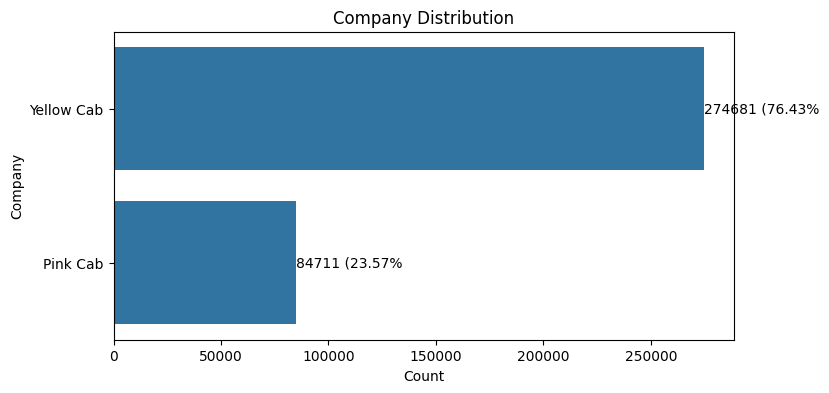

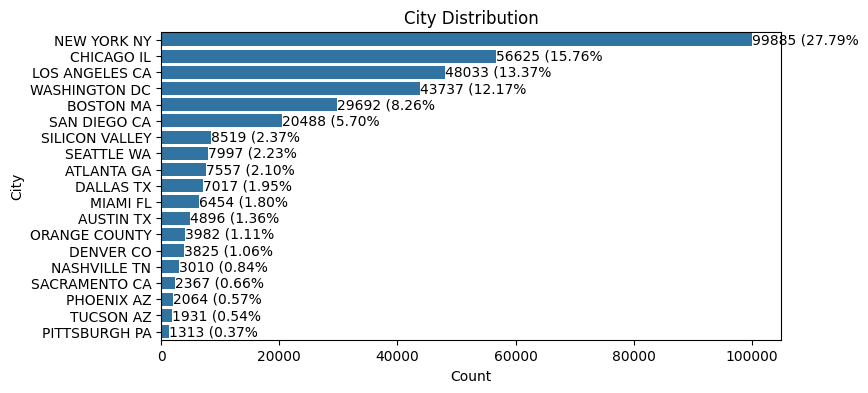

In [20]:
# Analysis of Categorical Variables

for col in cat_cols1:
    cat_summ(cab_data, col, plot = True)

 * Yellow Cab company has more presence with 76.43% of operations, than the Pink Cab company has a presense of 23.57%. That shows that the Yellow Cab is more successful than the Pink Cab.

 * Also we can see that New York, Chicago and Los angeles is their biggest base of operations in terms of transactions.

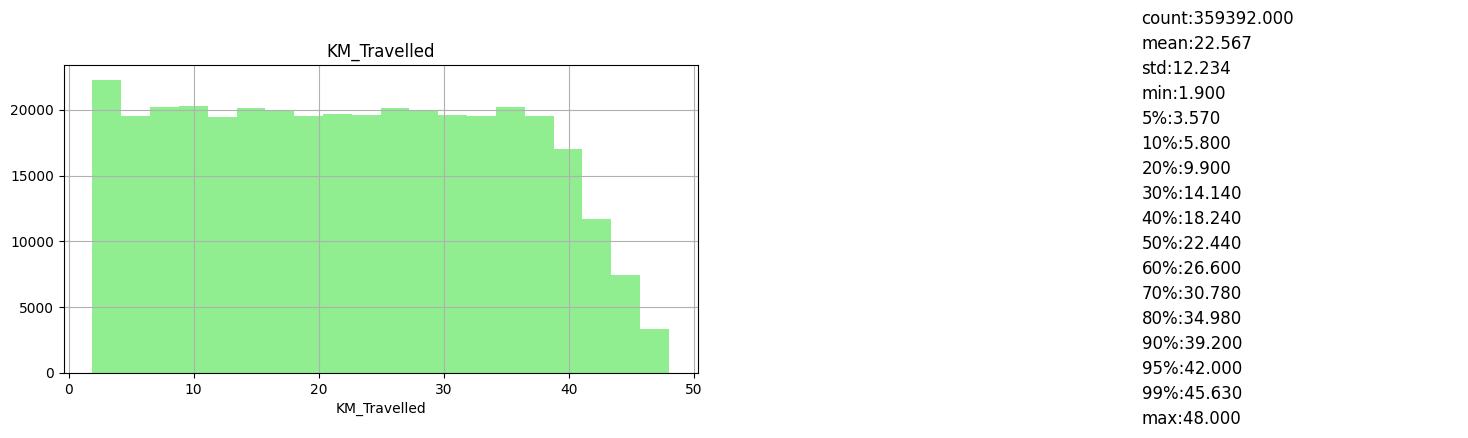

--------------------------------------------------


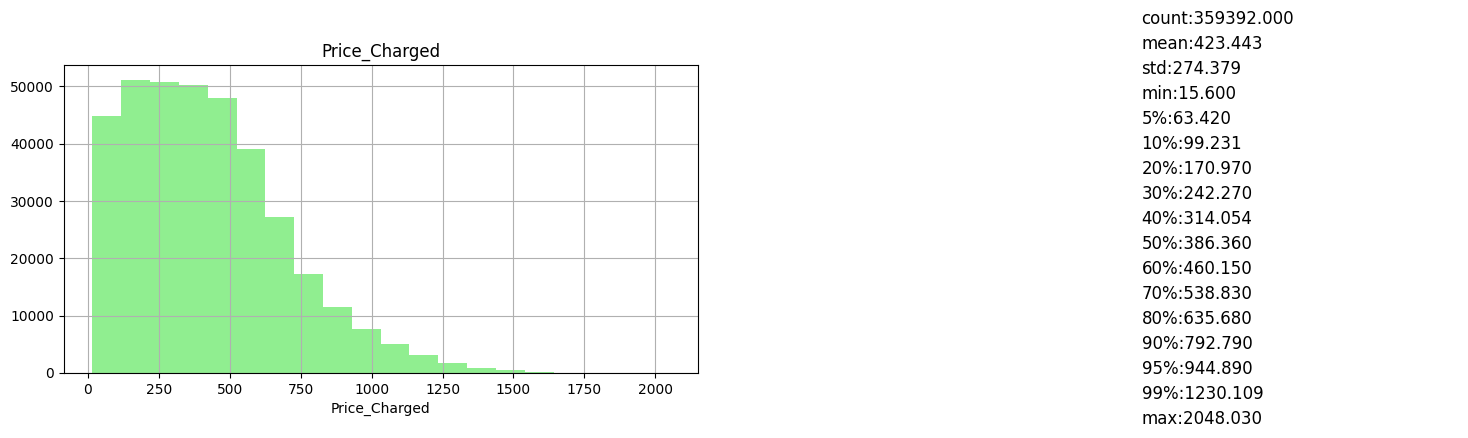

--------------------------------------------------


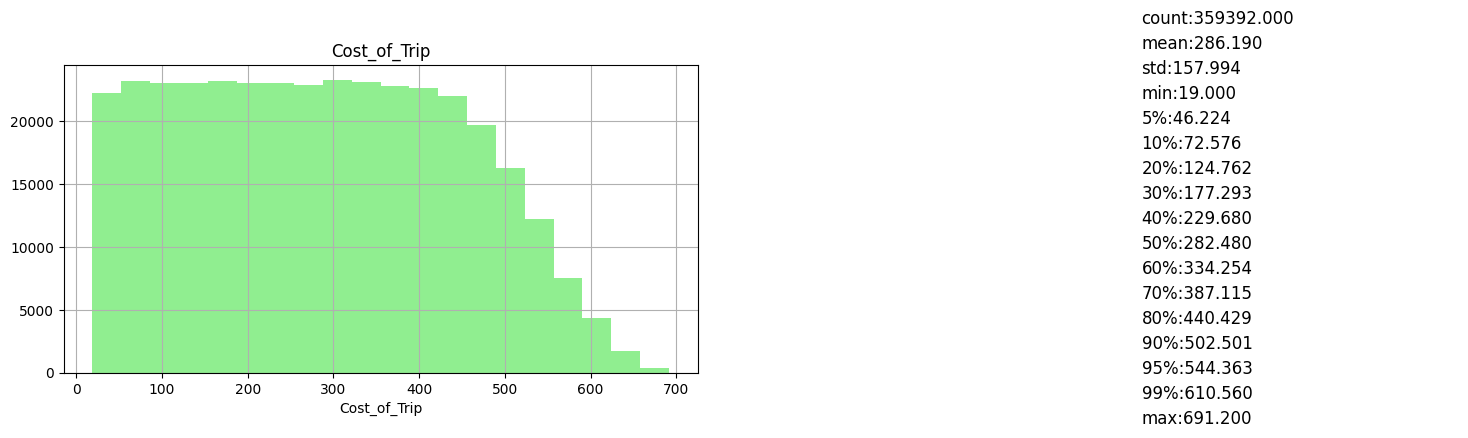

--------------------------------------------------


In [21]:
# Analysis of Numerical Variables

for col in num_cols1:
    num_summ(cab_data, col, plot = True)

* From the graph, we can see that the minimum distance covered is 1.9km showing that its a good business venture that meets various targets of people, and the maximum distance is 48km so they do cover large distances.

* From the graph, we can see that the dataset for the price change is left skewed and there is no normal distribution. There is a possiblity that there might outliers, as we can see that the maximum price rises to $2048 while the median value is $386.

* The cost of trip shows that the lowest price is "$19" which shows that the companies are pocket friendly and still afforable when you cover the large kilometers at "$691"
  

In [22]:
# Outlier Analysis

for col in num_cols1:
    print(col,find_outlier(cab_data, col))

KM_Travelled False
Price_Charged True
Cost_of_Trip False


Just as predicted the price charged column contains outliers that might affect the dataset when performing model evaluation

CUSTOMER_DATA DATAFRAME ANALYSIS

In [23]:
# show basic descriptive analysis
show_df(customer_data)

------------------ Shape -------------------
 Datashape: (49171, 4)

------------------ DataType -------------------
Customer ID            int64
Gender                object
Age                    int64
Income (USD/Month)     int64
dtype: object

------------------ Head -------------------
   Customer ID Gender  Age  Income (USD/Month)
0        29290   Male   28               10813
1        27703   Male   27                9237
2        28712   Male   53               11242
3        28020   Male   23               23327
4        27182   Male   33                8536
5        27318   Male   25               13984

------------------ Null Value -------------------
Customer ID           0
Gender                0
Age                   0
Income (USD/Month)    0
dtype: int64

------------------ Count -------------------
Customer ID           49171
Gender                49171
Age                   49171
Income (USD/Month)    49171
dtype: int64

------------------ nunique -------------------


The average age of the customers is 35 years old

The minimum age is 18 years which makes sense because of they are the ones that are mostly active especially at night for parties and maximum age is 65 years 

The average monthly imcome of the customers is around $14700 which shows that its a business that will continuously provide a steady income with rise in demand

No missing values are present in the dataset

In [24]:
# Checking for duplicates in the dataset
find_duplicates(customer_data)

No duplicate rows found in the dataframe.


In [25]:
# Changing the type of Customer ID datatype and print head

customer_data['Customer ID'] = customer_data['Customer ID'].astype(str)
customer_data.columns = customer_data.columns.str.replace(' ', '_')
customer_data.head()

,Customer_ID,Gender,Age,Income_(USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [26]:
#Show the datatype
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer_ID         49171 non-null  object
 1   Gender              49171 non-null  object
 2   Age                 49171 non-null  int64 
 3   Income_(USD/Month)  49171 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [27]:
# Capturing numerical and Categorical variables

cat_cols2, num_cols2, cat_but_car2 = get_col_names(customer_data)

Observations: 49171
Variables: 4
cat_cols: 1
num_cols: 2
cat_but_car: 1
num_but_cat: 0


In [28]:
# List all the categorical and numerical columns

cat_cols2, num_cols2, cat_but_car2

(['Gender'], ['Age', 'Income_(USD/Month)'], ['Customer_ID'])

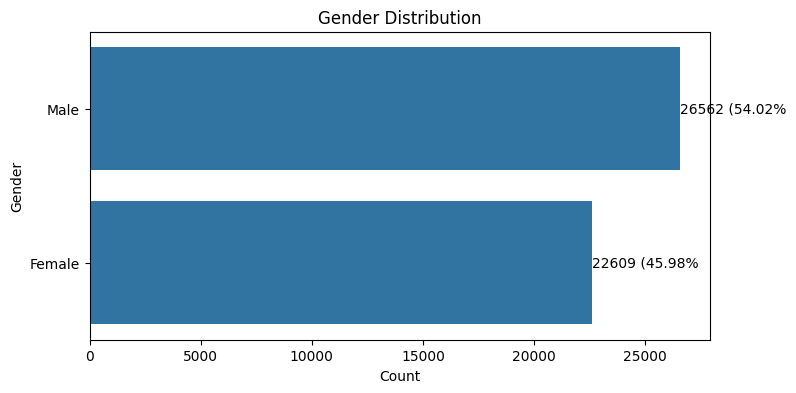

In [29]:
# Analysis of Categorical Variables

for col in cat_cols2:
    cat_summ(customer_data, col, plot=True)

From the histogram we can see the gender distribution of the customers, it shows that the male customers are about 54% of the distribution and while the female account for about 46%

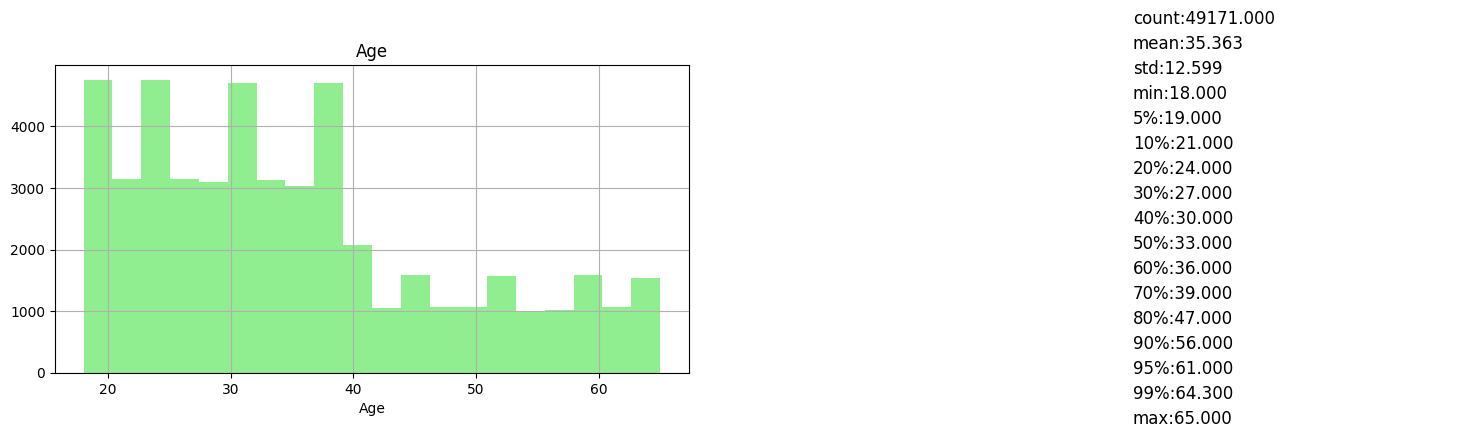

--------------------------------------------------


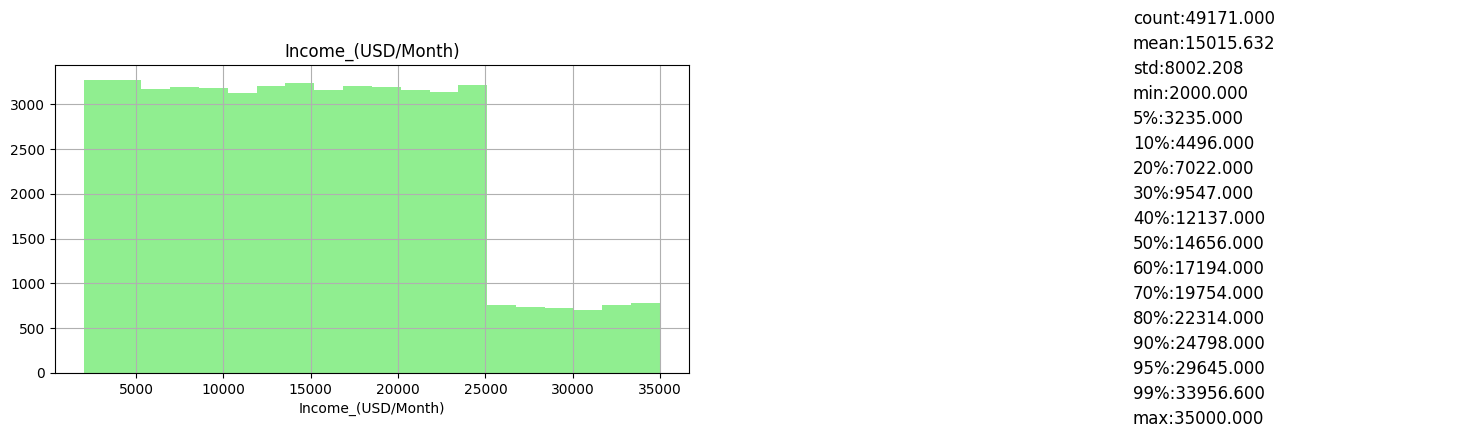

--------------------------------------------------


In [30]:
# Analysis of Numerical Variables

for col in num_cols2:
    num_summ(customer_data, col, plot=True)

*We can see that over 70% of the customers are under the age of 39 and the median age is 33.

*About the income of the customers it makes sense that the median income is about $15,000 because the cities which the company is doing very well its places that the cost of living is high due to the infastructure and top companies located in those areas.

In [31]:
# Outlier Analysis

for col in num_cols2:
    print(col, find_outlier(customer_data, col))

Age False
Income_(USD/Month) False


*This dataset is clean as it does not have any outlier so we can trust what the data is showing us

TRANSACTION DATA DATAFRAME ANALYSIS

In [32]:
# show basic descriptive analysis
show_df(transaction_data)

------------------ Shape -------------------
 Datashape: (440098, 3)

------------------ DataType -------------------
Transaction ID     int64
Customer ID        int64
Payment_Mode      object
dtype: object

------------------ Head -------------------
   Transaction ID  Customer ID Payment_Mode
0        10000011        29290         Card
1        10000012        27703         Card
2        10000013        28712         Cash
3        10000014        28020         Cash
4        10000015        27182         Card
5        10000016        27318         Cash

------------------ Null Value -------------------
Transaction ID    0
Customer ID       0
Payment_Mode      0
dtype: int64

------------------ Count -------------------
Transaction ID    440098
Customer ID       440098
Payment_Mode      440098
dtype: int64

------------------ nunique -------------------
Transaction ID    440098
Customer ID        49171
Payment_Mode           2
dtype: int64

------------------ Desscribe ----------------

*This data shows that there are two type of transaction method that are been used and which one is more preferred.

*There are no missing values

In [33]:
# Checking for duplicates
find_duplicates(transaction_data)

No duplicate rows found in the dataframe.


In [34]:
# Change the data type of the transaction and customer ID
transaction_data[['Transaction ID', 'Customer ID']] = transaction_data[['Transaction ID', 'Customer ID']].astype(str)
transaction_data.columns = transaction_data.columns.str.replace(' ', '_')

In [35]:
#Show the datatype
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction_ID  440098 non-null  object
 1   Customer_ID     440098 non-null  object
 2   Payment_Mode    440098 non-null  object
dtypes: object(3)
memory usage: 10.1+ MB


In [36]:
# Capturing numerical and Categorical variables

cat_cols3, num_cols3, cat_but_car3 = get_col_names(transaction_data)

Observations: 440098
Variables: 3
cat_cols: 1
num_cols: 0
cat_but_car: 2
num_but_cat: 0


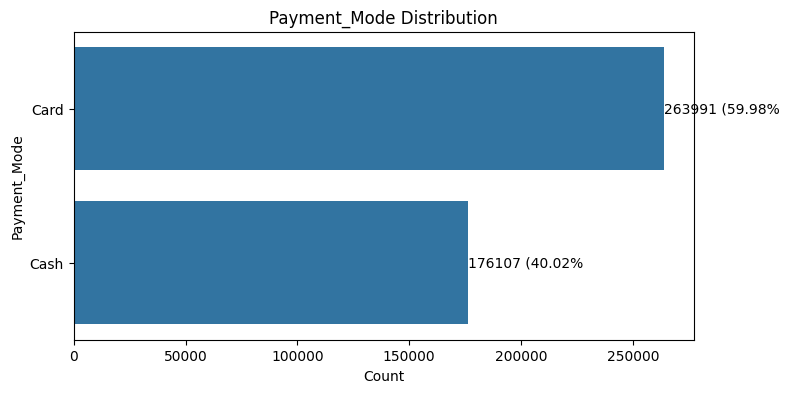

In [37]:
# Analysis of Categorical Variables

for col in cat_cols3:
    cat_summ(transaction_data, col, plot=True)

*We can see from the graph that 60% of the transactions have been paid with cards and the rest cash.

In [38]:
# show basic descriptive analysis
show_df(city_data)

------------------ Shape -------------------
 Datashape: (20, 3)

------------------ DataType -------------------
City          object
Population    object
Users         object
dtype: object

------------------ Head -------------------
             City   Population      Users
0     NEW YORK NY   8,405,837    302,149 
1      CHICAGO IL   1,955,130    164,468 
2  LOS ANGELES CA   1,595,037    144,132 
3        MIAMI FL   1,339,155     17,675 
4  SILICON VALLEY   1,177,609     27,247 
5   ORANGE COUNTY   1,030,185     12,994 

------------------ Null Value -------------------
City          0
Population    0
Users         0
dtype: int64

------------------ Count -------------------
City          20
Population    20
Users         20
dtype: int64

------------------ nunique -------------------
City          20
Population    20
Users         20
dtype: int64

------------------ Desscribe -------------------
               City   Population      Users
count            20           20         2

In [39]:
# Change the data type of the Population and Users

city_data['Population'] = city_data['Population'].str.replace(',', '').astype(float)
city_data['Users'] = city_data['Users'].str.replace(',', '').astype(float)

In [40]:
#Show the datatype
city_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        20 non-null     object 
 1   Population  20 non-null     float64
 2   Users       20 non-null     float64
dtypes: float64(2), object(1)
memory usage: 608.0+ bytes


In [41]:
# Checking for duplicates
find_duplicates(transaction_data)

No duplicate rows found in the dataframe.


In [42]:
# Capturing numerical and Categorical variables

cat_cols4, num_cols4, cat_but_car4 = get_col_names(city_data)

Observations: 20
Variables: 3
cat_cols: 0
num_cols: 2
cat_but_car: 1
num_but_cat: 0


In [43]:
# List all the categorical and numerical columns

num_cols4, cat_but_car4 

(['Population', 'Users'], ['City'])

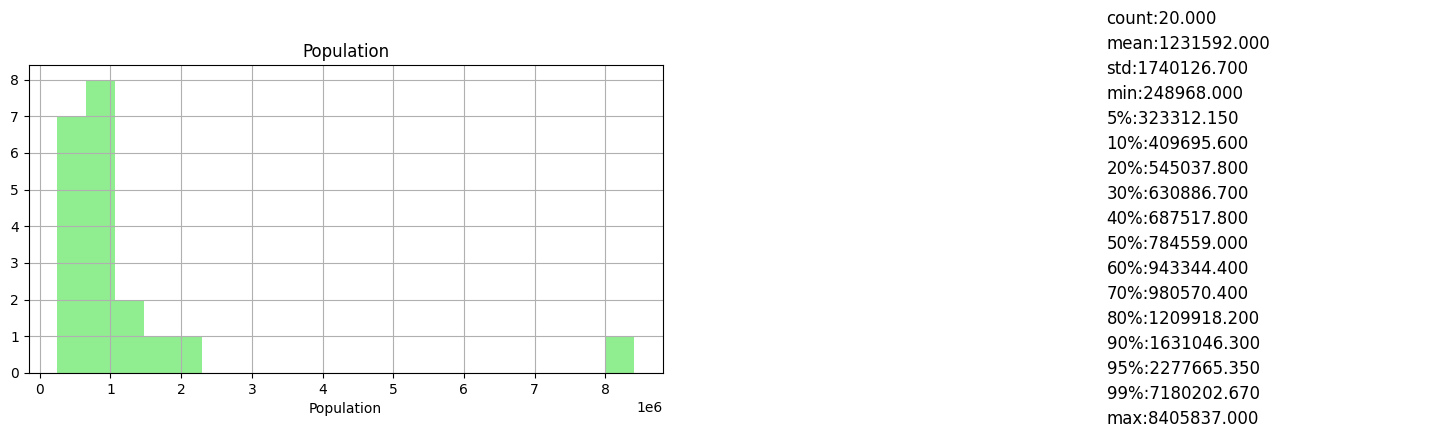

--------------------------------------------------


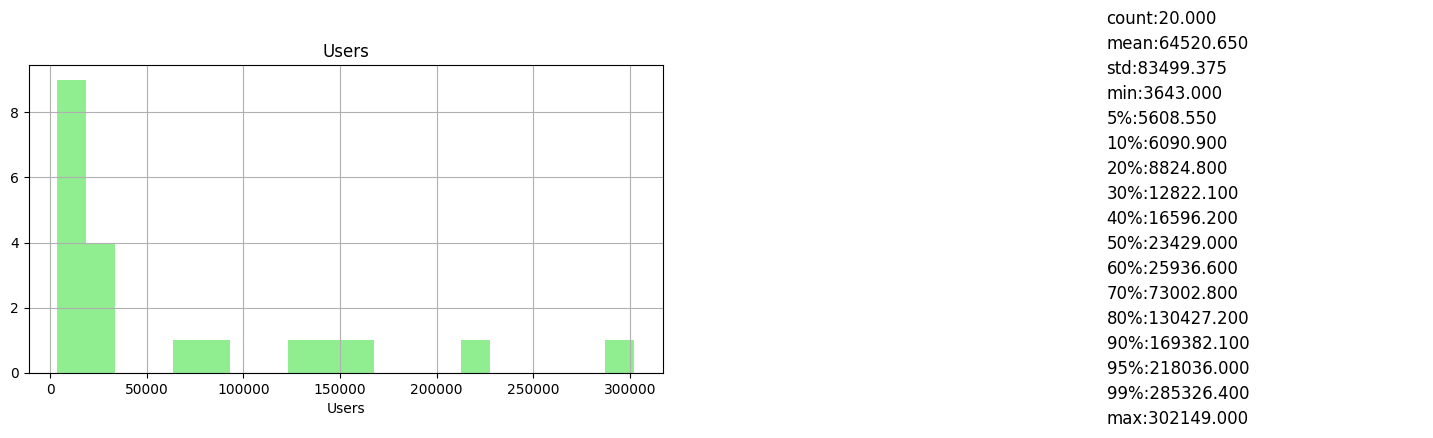

--------------------------------------------------


In [44]:
# Analysis of Numerical Variables

for col in num_cols4:
    num_summ(city_data, col, plot=True) 

* From the graph of the population we can see the population is right skewed,where the mean and median are inverse to each other and the values asre too high like there is possibilites of outliers

* The total number of users do not seem to be in an all time high but the busy cities make up for the large values which hint at the presence of outliers that is shown in the graph, the graph is not uniform as the values vary all through

In [45]:
#Outlier Analysis
for col in num_cols4:
    print(col, find_outlier(city_data, col))

Population True
Users True


* Just as predicted both the population and users data posses outliers

# MERGING THE WHOLE DATASET

In [46]:
# Merging cab and transaction datasets

merged_cab_transaction = pd.merge(cab_data, transaction_data, on = "Transaction_ID")
merged_cab_transaction.head(5)

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Customer_ID,Payment_Mode
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.450,370.950,313.635,29290,Card
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.620,358.520,334.854,27703,Card
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.040,125.200,97.632,28712,Cash
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.170,377.400,351.602,28020,Cash
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.730,114.620,97.776,27182,Card


In [47]:
# Merging customer and merged_cab_transaction datasets
merged_customer_cab_transaction = pd.merge(merged_cab_transaction, customer_data, on = "Customer_ID")
merged_customer_cab_transaction.head()

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Customer_ID,Payment_Mode,Gender,Age,Income_(USD/Month)
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.450,370.950,313.635,29290,Card,Male,28,10813
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.620,358.520,334.854,27703,Card,Male,27,9237
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.040,125.200,97.632,28712,Cash,Male,53,11242
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.170,377.400,351.602,28020,Cash,Male,23,23327
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.730,114.620,97.776,27182,Card,Male,33,8536


In [48]:
# Merging cab_data and city_data datasets
master_1 = pd.merge(merged_customer_cab_transaction, city_data, on = "City")
master_1.head(5)

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Customer_ID,Payment_Mode,Gender,Age,Income_(USD/Month),Population,Users
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.450,370.950,313.635,29290,Card,Male,28,10813,814885.000,24701.000
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.620,358.520,334.854,27703,Card,Male,27,9237,814885.000,24701.000
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.040,125.200,97.632,28712,Cash,Male,53,11242,814885.000,24701.000
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.170,377.400,351.602,28020,Cash,Male,23,23327,814885.000,24701.000
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.730,114.620,97.776,27182,Card,Male,33,8536,814885.000,24701.000


In [49]:
# Check the shape of the data
master_1.shape

(359392, 14)

* The data shape shows that the dataset is complete with no missing values

# CORRELATION ANALYSIS

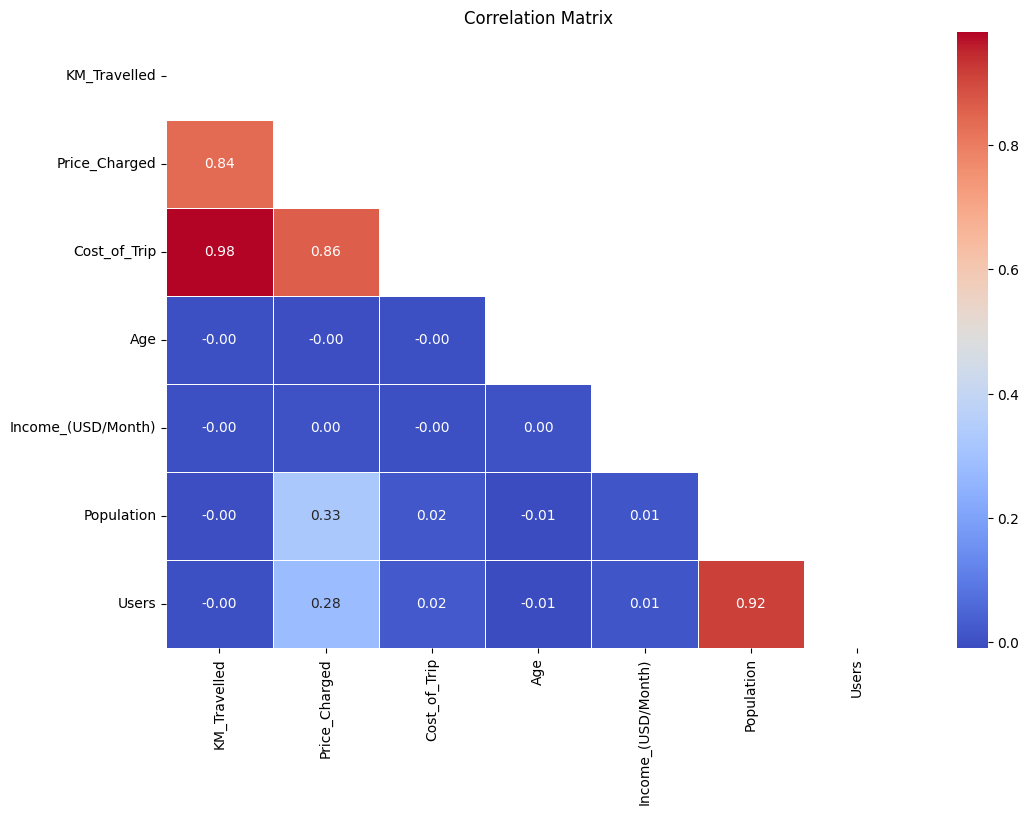

In [50]:
# Selecting only numeric columns
numeric_columns = master_1.select_dtypes(include = ["number"])
# Calculating the correlation matrix
correlation_matrix = numeric_columns.corr()

# Creating a lower-triangle mask to hide the upper part of the heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

plt.figure(figsize = (12,8))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", linewidths = 0.5, mask = mask)
plt.title("Correlation Matrix")
plt.show()

* From the pearson correlation matrix we can see that the strongest relationships are between KM_travelled, Cost_of_Trip and Price_Chanrged
as well as the population and users but the features Age and Income_(USD/Month) has no connection with others

In [52]:
# Create a copy of the master dataset
df_masters = master_1.copy()

In [53]:
# Calculating profit for each trip
df_masters["Profit"] = df_masters["Price_Charged"] - df_masters["Cost_of_Trip"]

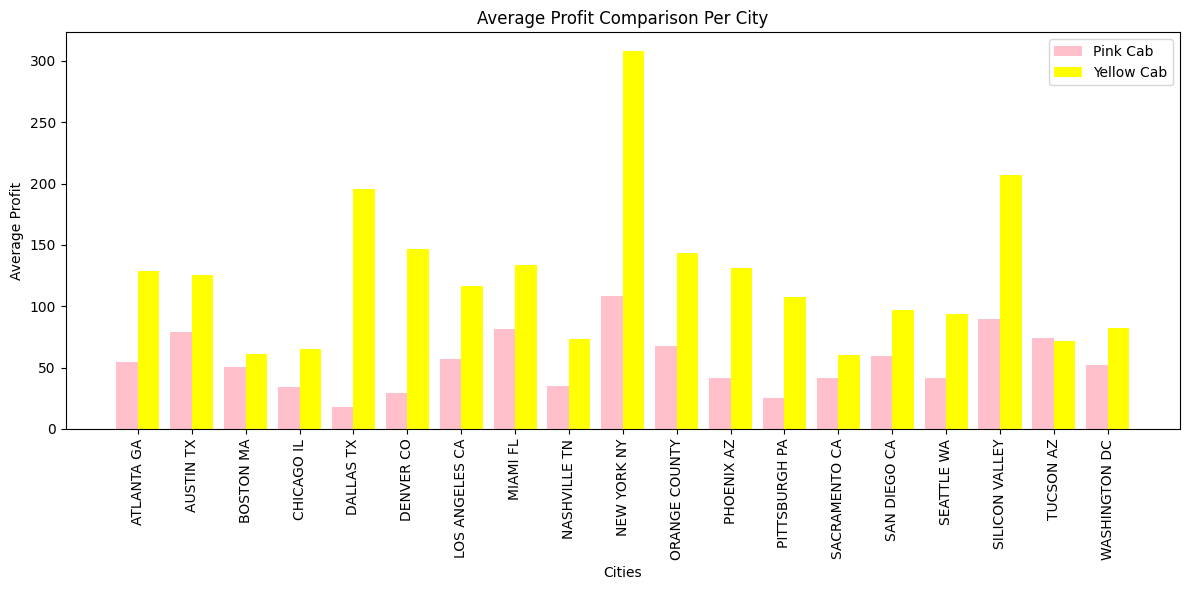

In [54]:
# CAlculating average profit per city for Pink Cab and Yellow Cab
city_profit = df_masters.groupby(["City", "Company"]).agg({"Profit" : "mean"}).unstack()

# Generating the bar chart
plt.figure(figsize = (12,6))
bar_width = 0.4
index = np.arange(len(city_profit.index))

plt.bar(index, city_profit["Profit"]["Pink Cab"], bar_width, label = "Pink Cab", color = "Pink")
plt.bar(index + bar_width, city_profit["Profit"]["Yellow Cab"], bar_width, label = "Yellow Cab", color = "yellow")

plt.xticks(index + bar_width / 2, city_profit.index, rotation = 90)
plt.xlabel("Cities")
plt.ylabel("Average Profit")
plt.title("Average Profit Comparison Per City")
plt.legend()

plt.tight_layout()
plt.show()

* From the graph we can see that the average profits are very high in New Yortk, Silicon Valley and Dallas TX because this areas are hot metropolitian areas that attracts people to build business, live and go to for tourist attarctions.

* Also it should be noted that the yellow cab company is doing well in this cities and everywhere else in general than the pink cab company

# PAYMENT MODE COMPARISON BY COMPANY

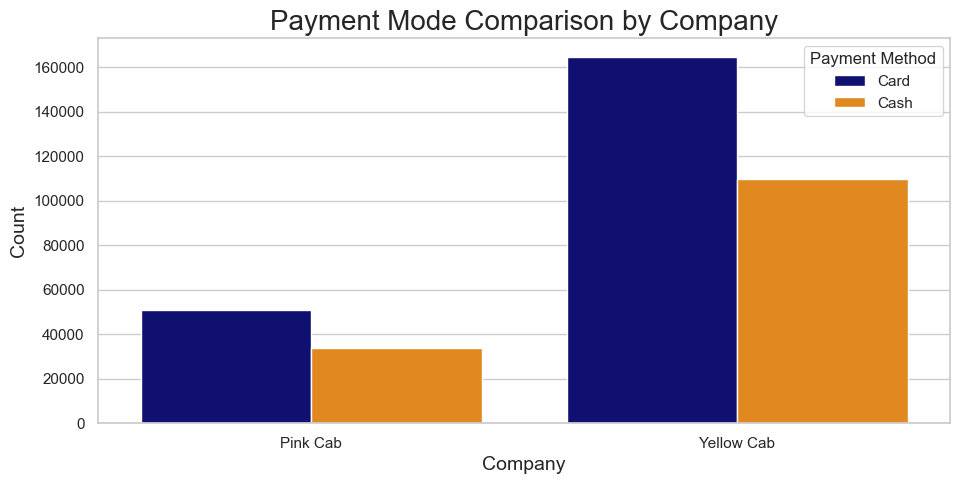

In [55]:
# Creating the graph

sns.set(style = "whitegrid")
plt.figure (figsize = (11,5))
sns.countplot(x = "Company", hue = "Payment_Mode", data = df_masters, palette = {"Card" : "navy", "Cash" : "darkorange"})

plt.title("Payment Mode Comparison by Company", fontsize = 20)
plt.xlabel("Company", fontsize = 14)
plt.ylabel("Count", fontsize = 14)

plt.legend(title = "Payment Method")

plt.show()

*We can see that most users prefer using card than cash for both companies

# Hypothesis 1: Is there a difference in profit based on payment mode?

H0 : There is no difference in profit based on payment mode.

H1 : There is a difference in profit based on payment mode.

--------------Assumptions checking for hypotheses------------------:

Functions below check the normality assumption of the data using the Shapiro-Wilk test and the homogeneity of variance using the Levene test before hypothesis tests.

If both assumptions (normality and homogeneity) are met, a parametric test is conducted.

If the normal distribution assumption is not met, non-parametric tests are conducted.

If normality is met but homogeneity is not, a parametric test can be conducted with the 'equal_var = False' argument

In [56]:
# Function for testing normality

def shapiro_test(x, y):
    test_stat_x, pvalue_x = shapiro(x)
    test_stat_y, pvalue_y = shapiro(y)
    if pvalue_x < 0.05:
        print("Test Stat = %.4f, p-value = %.4f" % (test_stat_x, pvalue_x),
              "HO is rejected, the assumption of normal distribution is not satisfied")
    else:
        print("Test Stat = %.4f, p-value = %.4f" % (test_stat_x, pvalue_x),
              "HO is not rejected, the assumption of normal distribution is satisfied")

In [57]:
# Function of homogeneity of variance

def levene_test(x,y):
    test_stat, pvalue = stats.levene(x,y)
    if pvalue <0.05:
        print("Test Stat = %.4f, p-value =%.4f" % (test_stat, pvalue),
              "HO is rejected, the homogeneity of variance is not satisfied")
    else:
        print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue),
              "HO is not rejected, the homogeneity of variance is satisfied")

# Pink Cab

In [58]:
# Calculating the average profit for cash transactions
cash_mean_profit_pink = df_masters[(df_masters.Company == "Pink Cab") & (df_masters.Payment_Mode == "Cash")]["Profit"].mean()
print("Average profit for cash transactions in pink cab: {:.3f}".format(cash_mean_profit_pink))

card_mean_profit_pink = df_masters[(df_masters.Company == "Pink Cab") & (df_masters.Payment_Mode == "Card")]["Profit"].mean()
print("Average profit for card transactions in pink cab: {:.3f}".format(card_mean_profit_pink))

Average profit for cash transactions in pink cab: 62.565
Average profit for card transactions in pink cab: 62.710


In [59]:
# Gathering all profits values for cash transactions
cash_profits_pink = df_masters[(df_masters.Company == "Pink Cab") & (df_masters.Payment_Mode == "Cash")]["Profit"]

# Gathering all profits values for card transactions
card_profits_pink = df_masters[(df_masters.Company == "Pink Cab") & (df_masters.Payment_Mode == "Card")]["Profit"]

In [60]:
# Assumption of normality:
# H0: The normal distribution assumption is satisfied.
# H1: The normal distribution assumption is not satisfied.
# p < 0.05 H0 is rejected, p > 0.05 H0 cannot be rejected.

# Assumptions
#############################################

# Normality
shapiro_test(cash_profits_pink, card_profits_pink)

# Homogeneity of variance
levene_test(cash_profits_pink, card_profits_pink)

Test Stat = 0.8616, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 0.7626, p-value = 0.3825 HO is not rejected, the homogeneity of variance is satisfied


From the test we can see that the normal distribution is not met, so a non-parametric test, namely the Mann-Whitney U test, will be conducted.

In [61]:
# Mann-Whitney U test function

def mann_whitney_u_test(group1, group2, alpha = 0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative = "two-sided")
    if p_value < alpha:
        print(f"Test Stat = {stat:4f}, p-value = {p_value:.4f}", "HO is rejected, there is a statistically significant difference between the groups")
    else:
        print(f"Test Stat = {stat:.4f}, p-value = {p_value:.4f}", "HO is not rejected, there is no statistically significant difference between the groups")

mann_whitney_u_test(cash_profits_pink, card_profits_pink)

Test Stat = 862495001.5000, p-value = 0.8917 HO is not rejected, there is no statistically significant difference between the groups


* From the analysis it shows that there is no signifcant difference in the payment made from both mode of payments as they yeild more or less the same average profits

# Yellow Cab

In [62]:
# Calculating the average profit for cash transaction
cash_mean_profit_yellow = df_masters[(df_masters.Company == "Yellow Cab") & (df_masters.Payment_Mode == "Cash")]["Profit"].mean()
print("Average profit for cash transactions in the yellow cab: {:.3f}".format(cash_mean_profit_yellow))

# Calculating the average profit for card transaction"
card_mean_profit_yellow = df_masters[(df_masters.Company == "Yellow Cab") & (df_masters.Payment_Mode == "Card")]["Profit"].mean()
print("Average profit for card transaction in the yellow cab: {:.3f}".format(card_mean_profit_yellow))

Average profit for cash transactions in the yellow cab: 160.682
Average profit for card transaction in the yellow cab: 159.979


In [63]:
# Listing all profits values for cash transactions
cash_profits_yellow = df_masters[(df_masters.Company == "Yellow Cab") & (df_masters.Payment_Mode == "Cash")]["Profit"]

# Listing all profits values for card transactions
card_profits_yellow = df_masters[(df_masters.Company == "Yellow Cab") & (df_masters.Payment_Mode == "Card")]["Profit"]

In [64]:
# Assumptions
#############################################

# Normality
shapiro_test(cash_profits_yellow, card_profits_yellow)

# Homogeneity of variance
levene_test(cash_profits_yellow, card_profits_yellow)

Test Stat = 0.8364, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 2.9896, p-value = 0.0838 HO is not rejected, the homogeneity of variance is satisfied


*From the test we can see that the normal distribution is not met, so a non-parametric test, namely the Mann-Whitney U test, will be conducted.

In [65]:
# Mann-Whitney U test function

def mann_whitney_u_test(group1, group2, alpha = 0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative = "two-sided")
    if p_value < alpha:
        print(f"Test Stat = {stat:.4f}, p-value = {p_value:.4f}", "HO is rejected, there is a statistically significant difference between the groups")
    else:
        print(f"Test Stat = {stat:.4f}, p-value = {p_value:.4f}", "HO is not rejected, there is not a statistically significant difference between the groups")

mann_whitney_u_test(cash_profits_yellow, card_profits_yellow)

Test Stat = 9056262516.0000, p-value = 0.9352 HO is not rejected, there is not a statistically significant difference between the groups


* From the analysis it shows that there is no signifcant difference in the payment made from both mode of payments as they yeild more or less the same average profits

# Company and Gender

In [66]:
# Show the group by gender
df_masters.groupby(["Company", "Gender"])["Customer_ID"].nunique()

Company     Gender
Pink Cab    Female    14819
            Male      17511
Yellow Cab  Female    18394
            Male      21502
Name: Customer_ID, dtype: int64

In [67]:
grouped = df_masters.groupby(["Company", "Gender"])["Customer_ID"].nunique().reset_index()

Text(0.5, 1.0, 'Count of Customers by Company and Gender')

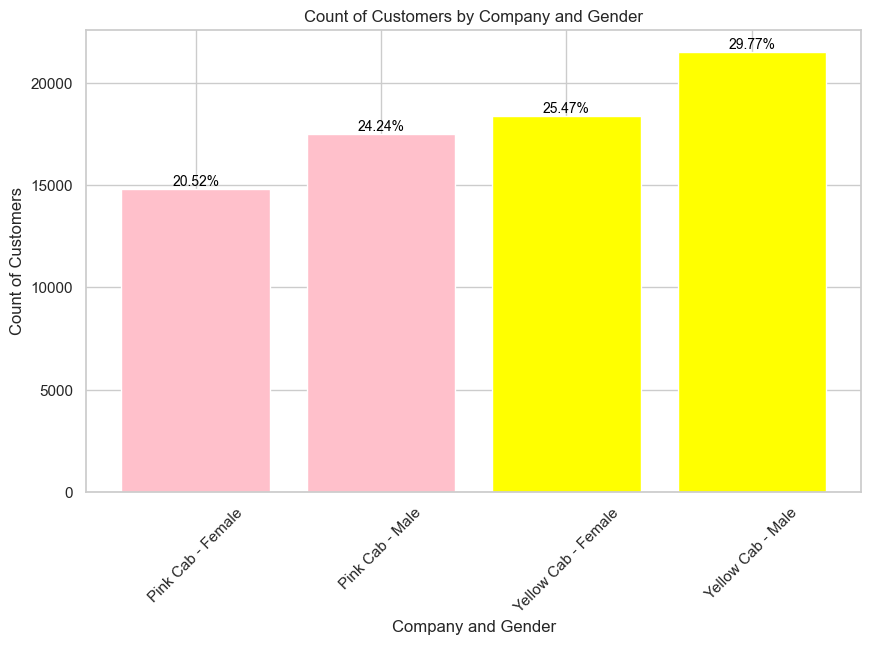

In [68]:
# Visualization
colors = {"Pink Cab" : "pink", "Yellow Cab" : "yellow"}

plt.figure(figsize = (10,6))
bars = []

for i, (company, gender, count) in grouped.iterrows():
    label = f"{company} - {gender}"
    total_customers = grouped["Customer_ID"].sum()
    percentage = (count / total_customers) * 100
    plt.bar(label, count, color = colors[company])
    plt.text(label, count, f"{percentage:.2f}%", ha = "center", va = "bottom", fontsize = 10, color = "black")

plt.xlabel("Company and Gender")
plt.ylabel("Count of Customers")
plt.xticks(range(len(grouped)), ["{} - {}".format(company, gender) for company, gender in zip(grouped["Company"], grouped["Gender"])], rotation = 45)
plt.title("Count of Customers by Company and Gender")

# Hypothesis 2: Is there a significant difference in profit based on gender?

H0 : There is no difference in profit based on gender.

H1 : There is a difference in profit based on gender.

In [69]:
# Calculating the number of female and male customers for the pink cab company
pink_cab_female_customers = df_masters[(df_masters["Company"] == "Pink Cab") & (df_masters["Gender"] == "Female")]["Customer_ID"].nunique()
pink_cab_male_customers = df_masters[(df_masters["Company"] == "Pink Cab") & (df_masters["Gender"] == "Male")]["Customer_ID"].nunique()

print("Pink cab female customers:", pink_cab_female_customers)
print("Pink cab male customers:", pink_cab_male_customers)

# CALCULATING THE TOTAL AND MEAN PROFIT FOR FEMALE AND MALE CUSTOMERS OF THE PINK CAB
pink_cab_male_total_profit = df_masters[(df_masters["Company"] == "Pink Cab") & (df_masters["Gender"] == "Male")]["Profit"].sum()
pink_cab_female_total_profit = df_masters[(df_masters["Company"] == "Pink Cab") & (df_masters["Gender"] == "Female")]["Profit"].sum()

pink_cab_male_mean_profit = df_masters[(df_masters["Company"] == "Pink Cab") & (df_masters["Gender"] == "Male")]["Profit"].mean()
pink_cab_female_mean_profit = df_masters[(df_masters["Company"] == "Pink Cab") & (df_masters["Gender"] == "Female")]["Profit"].mean()

print("Pink cab male total profit:", pink_cab_male_total_profit)
print("Pink cab female total profit:", pink_cab_female_total_profit)
print("Pink cab male mean profit:", pink_cab_male_mean_profit)
print("Pink cab female mean profit:", pink_cab_female_mean_profit)

Pink cab female customers: 14819
Pink cab male customers: 17511
Pink cab male total profit: 2976795.63
Pink cab female total profit: 2330532.691
Pink cab male mean profit: 63.026309627151655
Pink cab female mean profit: 62.18070146744931


In [70]:
# Gathering all profits values for both male and female using the pink cab
pinkc_male = df_masters[(df_masters["Company"] == "Pink Cab") & (df_masters["Gender"] == "Male")]["Profit"]
pinkc_female = df_masters[(df_masters["Company"] == "Pink Cab") & (df_masters["Gender"] == "Female")]["Profit"]

In [71]:
# Assumptions
#############################################

# Normality
shapiro_test(pinkc_female, pinkc_male)

# Homogeneity of variance
levene_test(pinkc_female, pinkc_male)

Test Stat = 0.8629, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 0.6671, p-value = 0.4141 HO is not rejected, the homogeneity of variance is satisfied


In [72]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(pinkc_female, pinkc_male)

Test Stat = 879754157.5000, p-value = 0.1298 HO is not rejected, there is not a statistically significant difference between the groups


* From the analysis it shows that there is no signifcant difference in the profits bassed on gender as they yeild more or less the same average profits

# Yellow Cab

In [73]:
# Calculating the number of female and male customers for the yellow cab
yellow_cab_female_customers = df_masters[(df_masters["Company"] == "Yellow Cab") & (df_masters["Gender"] == "Female")]["Customer_ID"].nunique()
yellow_cab_male_customers = df_masters[(df_masters["Company"] == "Yellow Cab") & (df_masters["Gender"] == "Male")]["Customer_ID"].nunique()

print("Number of female yellow cab customers:", yellow_cab_female_customers)
print("Number of male yellow cab customers:", yellow_cab_male_customers)

# Calculating the sum of profits for the customers for the yellow cab
yellow_cab_female_total_profit = df_masters[(df_masters["Company"] == "Yellow Cab") & (df_masters["Gender"] == "Female")]["Profit"].sum()
yellow_cab_male_total_profit = df_masters[(df_masters["Company"] == "Yellow Cab") & (df_masters["Gender"] == "Male")]["Profit"].sum()

# Calcualting the mean of profits for the customers for the yellow cab
yellow_cab_female_mean_profit = df_masters[(df_masters["Company"] == "Yellow Cab") & (df_masters["Gender"] == "Female")]["Profit"].mean()
yellow_cab_male_mean_profit = df_masters[(df_masters["Company"] == "Yellow Cab") & (df_masters["Gender"] == "Male")]["Profit"].mean()

print("Total profit of female yellow cab customers:", yellow_cab_female_total_profit)
print("Total profit of male yellow cab customers:", yellow_cab_male_total_profit)
print("Mean profit of female yellow cab customers:", yellow_cab_female_mean_profit)
print("Mean profit of male yellow cab customers:", yellow_cab_male_mean_profit)


Number of female yellow cab customers: 18394
Number of male yellow cab customers: 21502
Total profit of female yellow cab customers: 18131417.6532
Total profit of male yellow cab customers: 25888955.5176
Mean profit of female yellow cab customers: 156.30532459655174
Mean profit of male yellow cab customers: 163.1509476093546


In [74]:
# Lisiting all the profits of each gender
yellowc_female = df_masters[(df_masters["Company"] == "Yellow Cab") & (df_masters["Gender"] == "Female")]["Profit"]
yellowc_male = df_masters[(df_masters["Company"] == "Yellow Cab") & (df_masters["Gender"] == "Male")]["Profit"]

In [75]:
# Assumptions
#############################################

# Normality
shapiro_test(yellowc_female, yellowc_male)

# Homogeneity of variance
levene_test(yellowc_female, yellowc_male)

Test Stat = 0.8349, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 104.1823, p-value =0.0000 HO is rejected, the homogeneity of variance is not satisfied


In [76]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(yellowc_female, yellowc_male)

Test Stat = 9034571934.0000, p-value = 0.0000 HO is rejected, there is a statistically significant difference between the groups


* From the analysis it shows that there is a significant difference in profits distribution of male and female as the male make up more of the total profits for the cab and now we know the main targets of our campaigns

# Income of Cab Customers

In [77]:
unique_customer_incomes = df_masters.groupby("Customer_ID")["Income_(USD/Month)"].mean()

# Calculating the mean income (USD/Month) for customers of each taxi company
pink_cab_income_mean = df_masters[df_masters["Company"] == "Pink Cab"].groupby("Customer_ID")["Income_(USD/Month)"].mean().mean()
yellow_cab_income_mean = df_masters[df_masters["Company"] == "Yellow Cab"].groupby("Customer_ID")["Income_(USD/Month)"].mean().mean()

print("Pink Cab Income Mean:", pink_cab_income_mean)
print("Yellow Cab Income Mean:", yellow_cab_income_mean)

Pink Cab Income Mean: 15034.097618311165
Yellow Cab Income Mean: 14983.896831762582


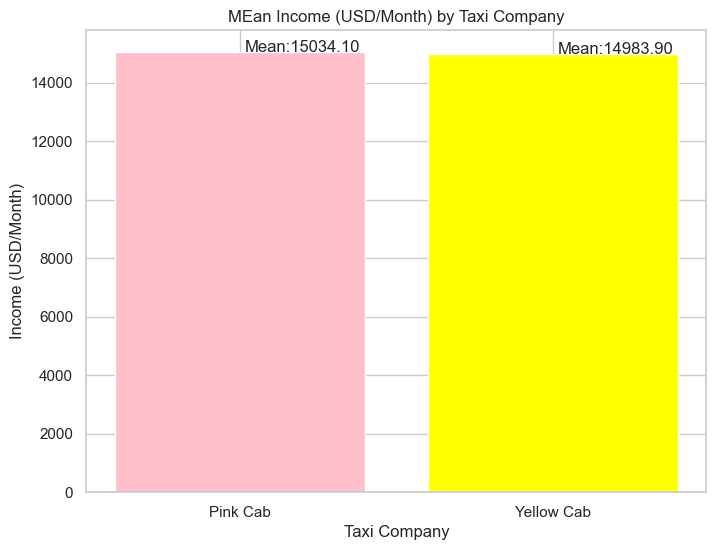

In [78]:
# Creating a bar chart comparing the mean income_(USD/Month) for the two companies
companies = ["Pink Cab", "Yellow Cab"]
income_means = [pink_cab_income_mean, yellow_cab_income_mean]

plt.figure(figsize = (8,6))
bars = plt.bar(companies, income_means, color = ["pink", "yellow"])
plt.xlabel("Taxi Company")
plt.ylabel("Income (USD/Month)")
plt.title("MEan Income (USD/Month) by Taxi Company")

for bar, income_mean in zip(bars, income_means):
    plt.text(bar.get_x() + bar.get_width() - 0.2, bar.get_height(), f"Mean:{income_mean:.2f}", ha = "center")

plt.show()

# Hypothesis 3: Is there a significant difference in the incomes of Yellow Cab and Pink Cab customers?

H0 : There is no difference in the incomes of Yellow Cab and Pink Cab customers.

H1 : There is a difference in the incomes of Yellow Cab and Pink Cab customers.

In [79]:
# Performing a hypothesis test
pink_cab_income = df_masters[df_masters['Company'] == 'Pink Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean()
yellow_cab_income = df_masters[df_masters['Company'] == 'Yellow Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean()

# Assumptions
#############################################

# Normality
shapiro_test(pink_cab_income, yellow_cab_income)

# Homogeneity of variance
levene_test(pink_cab_income, yellow_cab_income)

Test Stat = 0.9707, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 0.0395, p-value = 0.8424 HO is not rejected, the homogeneity of variance is satisfied


In [80]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(pink_cab_income, yellow_cab_income)

Test Stat = 647299744.0000, p-value = 0.3928 HO is not rejected, there is not a statistically significant difference between the groups


* From the analysis it shows that there is no difference betwwen the income of both company users

# Distribution of cab users among companies over the years

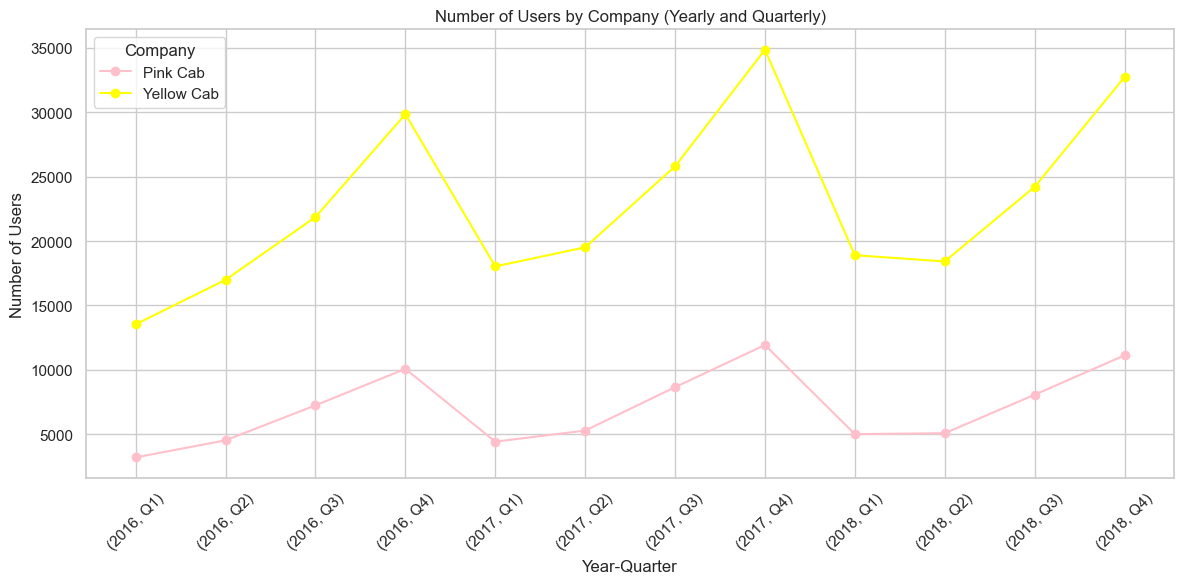

In [81]:
# Extracting year and quarter
df_masters['Year'] = pd.to_datetime(df_masters['Date_of_Travel']).dt.year
df_masters['Quarter'] = pd.to_datetime(df_masters['Date_of_Travel']).dt.quarter

# Grouping the data by year, quarter, and company
yearly_quarterly_data = df_masters.groupby(['Year', 'Quarter', 'Company'])['Customer_ID'].count().unstack().fillna(0)

# Visualization
unique_years = sorted(df_masters['Year'].unique())
colors = ['pink', 'yellow']

ax = yearly_quarterly_data.plot(kind='line', marker='o', figsize=(12, 6), color=colors)
plt.title('Number of Users by Company (Yearly and Quarterly)')
plt.xlabel('Year-Quarter')
plt.ylabel('Number of Users')
plt.legend(title='Company', loc='best')
plt.grid(True)

x_ticks = [f'({year}, Q{quarter})' for year in unique_years for quarter in range(1, 5)]
ax.set_xticks(range(len(x_ticks)))
ax.set_xticklabels(x_ticks, rotation=45)

plt.tight_layout()
plt.show()

* From the graph we can see that there has been increase and decrease in number of users of the cab company, but the yellow cab tend to make more profit than the pink cab

# The Impact of Loyal Customers and Champions on Profit in Yellow Cab and Pink Cab Companies

In [82]:
# Separating customers according to company

pink_cab_customers = df_masters[df_masters["Company"] == "Pink Cab"]
yellow_cab_customers = df_masters[df_masters["Company"] == "Yellow Cab"]

In [83]:
# Know the maximum date of travel
df_masters["Date_of_Travel"].max()

datetime.date(2018, 12, 31)

In [84]:
# The analysis date selected is two days after the date above
today_date = dt.date(2019, 1, 2)

RFM - Pink Cab

In [85]:
rfm_pink_cab = pink_cab_customers.groupby('Customer_ID').agg({'Date_of_Travel': lambda Date_of_Travel: (today_date - Date_of_Travel.max()).days,
                                     'Transaction_ID': lambda Transaction_ID: Transaction_ID.nunique(),
                                     'Price_Charged': lambda Price_Charged: Price_Charged.sum()})
rfm_pink_cab.columns = ['recency', 'frequency', 'monetary']
rfm_pink_cab.head()

,recency,frequency,monetary
Customer_ID,,,
1,388,4,2286.480
10,157,3,1001.490
100,439,4,1934.620
1000,72,6,2813.150
10001,33,1,28.650


In [86]:
# Show a describtion of the data
rfm_pink_cab.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,32330.000,340.657,292.521,2.000,81.000,272.000,517.000,1096.000
frequency,32330.000,2.620,2.194,1.000,1.000,2.000,3.000,18.000
monetary,32330.000,814.360,762.878,15.600,294.532,543.455,1092.140,6568.900


In [87]:
# Calculating RFM Scores

rfm_pink_cab["recency_score"] = pd.qcut(rfm_pink_cab['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm_pink_cab["frequency_score"] = pd.qcut(rfm_pink_cab['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm_pink_cab["monetary_score"] = pd.qcut(rfm_pink_cab['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_pink_cab["RFM_SCORE"] = (rfm_pink_cab['recency_score'].astype(str) +
                    rfm_pink_cab['frequency_score'].astype(str))

In [88]:
# Creating & Analysing RFM Segments

seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

url = "https://cdn.enhencer.com/website-assets/images/blog/AdvantagesAndInefficaciesOfRFMSegmentation1.png"
Image(url=url, width=600, height=400)

In this section, the focus will be on the 'Champions' and 'Loyal Customers' segments as seen in the above chart.

In [89]:
rfm_pink_cab['segment'] = rfm_pink_cab['RFM_SCORE'].replace(seg_map, regex=True)

rfm_pink_cab.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer_ID,,,,,,,,
1,388,4,2286.480,2,4,5,24,at_risk
10,157,3,1001.490,4,4,4,44,loyal_customers
100,439,4,1934.620,2,4,5,24,at_risk
1000,72,6,2813.150,4,5,5,45,loyal_customers
10001,33,1,28.650,5,1,1,51,new_customers


In [90]:
# Number of 'Champions' and 'Loyal Customers' - Pink Cab

loyal_customers_champions_count = rfm_pink_cab[(rfm_pink_cab['segment'] == 'loyal_customers') | (rfm_pink_cab['segment'] == 'champions')].shape[0]

print("Loyal Customers + Champions Count:", loyal_customers_champions_count)

Loyal Customers + Champions Count: 10923


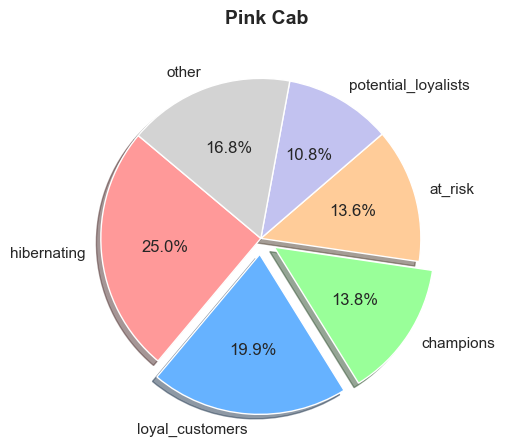

In [91]:
# Calculating segment proportions
segment_proportions = rfm_pink_cab['segment'].value_counts(normalize=True)

# Getting the top 5 segments by proportion
top_segments = segment_proportions.nlargest(5).index.tolist()

# Grouping other segments as "Other"
other_proportion = 1 - segment_proportions[top_segments].sum()
segment_proportions['other'] = other_proportion

# Defining colors
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#c2c2f0', 'lightgrey']

# Creating a pie chart
explode = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in segment_proportions.index]

# Filtering for the top segments and "other"
filtered_proportions = segment_proportions[top_segments + ['other']]
filtered_explode = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in filtered_proportions.index]

plt.pie(filtered_proportions, labels=filtered_proportions.index, autopct='%1.1f%%', shadow=True, colors=colors, startangle=140, explode=filtered_explode)
plt.axis('equal')


plt.title("Pink Cab", loc="center", y=1.08, fontsize=14, fontweight='bold')

plt.show()

RFM - Yellow Cab

In [92]:
rfm_yellow_cab = yellow_cab_customers.groupby('Customer_ID').agg({'Date_of_Travel': lambda Date_of_Travel: (today_date - Date_of_Travel.max()).days,
                                     'Transaction_ID': lambda Transaction_ID: Transaction_ID.nunique(),
                                     'Price_Charged': lambda Price_Charged: Price_Charged.sum()})
rfm_yellow_cab.columns = ['recency', 'frequency', 'monetary']
rfm_yellow_cab.head()

,recency,frequency,monetary
Customer_ID,,,
1,17,25,15203.650
10,11,21,11906.240
100,14,35,21660.870
1000,39,27,14081.770
10000,365,2,963.070


In [93]:
# Show a describtion of the data
rfm_yellow_cab.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,39896.000,262.796,279.443,2.000,40.000,133.000,425.000,1096.000
frequency,39896.000,6.885,8.183,1.000,1.000,3.000,10.000,47.000
monetary,39896.000,3154.549,4602.075,24.790,556.057,1260.965,3895.115,32351.360


In [94]:
# Calculating RFM Scores

rfm_yellow_cab["recency_score"] = pd.qcut(rfm_yellow_cab['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm_yellow_cab["frequency_score"] = pd.qcut(rfm_yellow_cab['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm_yellow_cab["monetary_score"] = pd.qcut(rfm_yellow_cab['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_yellow_cab["RFM_SCORE"] = (rfm_yellow_cab['recency_score'].astype(str) +
                    rfm_yellow_cab['frequency_score'].astype(str))

In [95]:
rfm_yellow_cab['segment'] = rfm_yellow_cab['RFM_SCORE'].replace(seg_map, regex=True)

rfm_yellow_cab.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer_ID,,,,,,,,
1,17,25,15203.650,5,5,5,55,champions
10,11,21,11906.240,5,5,5,55,champions
100,14,35,21660.870,5,5,5,55,champions
1000,39,27,14081.770,4,5,5,45,loyal_customers
10000,365,2,963.070,2,2,3,22,hibernating


In [96]:
# Number of 'Champions' and 'Loyal Customers' - Yellow Cab

loyal_customers_champions_count_y = rfm_yellow_cab[(rfm_yellow_cab['segment'] == 'loyal_customers') | (rfm_yellow_cab['segment'] == 'champions')].shape[0]

print("Loyal Customers + Champions Count:", loyal_customers_champions_count_y)

Loyal Customers + Champions Count: 14812


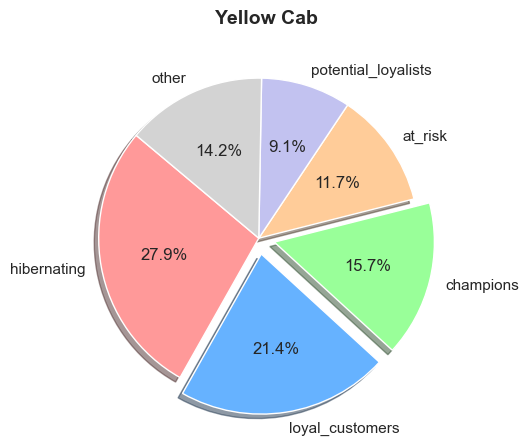

In [97]:
# Calculating segment proportions
segment_proportions_yellow = rfm_yellow_cab['segment'].value_counts(normalize=True)

# Getting the top 5 segments by proportion
top_segments_yellow = segment_proportions_yellow.nlargest(5).index.tolist()

# Grouping other segments as "other"
other_proportion_y = 1 - segment_proportions_yellow[top_segments_yellow].sum()
segment_proportions_yellow['other'] = other_proportion_y

# Defining colors
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#c2c2f0', 'lightgrey']

# Creating a pie chart
explode = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in segment_proportions_yellow.index]

# Filtering for the top segments and "other"
filtered_proportions_y = segment_proportions_yellow[top_segments_yellow + ['other']]
filtered_explode_y = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in filtered_proportions_y.index]

plt.pie(filtered_proportions_y, labels=filtered_proportions_y.index, autopct='%1.1f%%', shadow=True, colors=colors, startangle=140, explode=filtered_explode_y)
plt.axis('equal')


plt.title("Yellow Cab", loc="center", y=1.08, fontsize=14, fontweight='bold')

plt.show()

Hypothesis 4: Is there a significant difference in the contribution to Profit among loyal customers of the two companies?

H0 : There is no difference in the contribution to Profit among loyal customers of the two companies.

H1 : There is a difference the contribution to Profit among loyal customers of the two companies.

In [98]:
rfm_pink_cab['Profit'] = pink_cab_customers.groupby('Customer_ID')['Profit'].sum()
rfm_yellow_cab['Profit'] = yellow_cab_customers.groupby('Customer_ID')['Profit'].sum()

In [99]:

pink_cab_p = rfm_pink_cab[(rfm_pink_cab['segment'] == 'loyal_customers') | (rfm_pink_cab['segment'] == 'champions')]['Profit']
yellow_cab_y = rfm_yellow_cab[(rfm_yellow_cab['segment'] == 'loyal_customers') | (rfm_yellow_cab['segment'] == 'champions')]['Profit']

In [100]:
# Normality
shapiro_test(pink_cab_p, yellow_cab_y)

# Homogeneity of variance
levene_test(pink_cab_p, yellow_cab_y)

Test Stat = 0.9051, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 3236.7792, p-value =0.0000 HO is rejected, the homogeneity of variance is not satisfied


In [101]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(pink_cab_p, yellow_cab_y)

Test Stat = 13849021.5000, p-value = 0.0000 HO is rejected, there is a statistically significant difference between the groups


In [102]:
pink_cab_profit = pink_cab_p.sum()
yellow_cab_profit = yellow_cab_y.sum()

if pink_cab_profit > yellow_cab_profit:
    print("Pink Cab's loyal customers and champions generate more profit than Yellow Cab's.")
elif pink_cab_profit < yellow_cab_profit:
    print("Yellow Cab's loyal customers and champions generate more profit than Pink Cab's.")
else:
    print("Pink Cab's loyal customers and champions generate the same profit as Yellow Cab's.")

Yellow Cab's loyal customers and champions generate more profit than Pink Cab's.
